### 阶段三：ACT模型学习（多位置，无视觉）

要实现“任意位置物体抓取”的关键变化
你必须加入 视觉信息作为模型的输入，这样模型才能根据图像推断物体位置、再做出对应动作。 ✅ 你的目标 实现一个低成本系统，使得 LeRobot 能：

🚀 自主完成：无需人为控制

📍 抓取工作空间内任意位置的该物体

📦 物体种类不变（同一方块）

✅ 支持 2D 平面上的位置变化（X/Y 变，Z 不变

🧠 3. 模型“泛化能力”的本质是什么？
你说得对：

❗训练数据中只有 4 个固定位置 → 模型也只能学会“在这4个空间位置”如何抓取。

如果你把物体放在：

✅ 训练过的位置附近 → 模型可能抓得准（比如 clip_0011 和 clip_0012 之间插值）

❌ 没见过的新区域（比如 clip_0050 位置） → 完全不知道物体在哪儿，只能瞎抓

📷 4. 没有图片，那机器人是“瞎子”！ 所以，光靠关节状态做训练的模型无法定位新物体位置，因为：

它没有 任何视觉输入

它无法像人一样观察环境，判断物体的新位置

就像你训练了一个小孩：告诉他“你在这个姿态时，往前伸手可以抓到杯子”，但没有教他如何“找到杯子”，他就只能在记忆中找抓法，而不是感知现实。



In [1]:
# ✅ Cell 1：初始化机器人与相机（增强版）
import os, time, threading
import numpy as np
import cv2
from datetime import datetime
from pathlib import Path

from lerobot.common.robot_devices.robots.configs import KochRobotConfig
from lerobot.common.robot_devices.robots.manipulator import ManipulatorRobot
from lerobot.common.robot_devices.cameras.configs import OpenCVCameraConfig

# 设置机器人配置
robot_cfg = KochRobotConfig()
robot_cfg.cameras = {
    "e22s_side": OpenCVCameraConfig(camera_index=0, fps=30, width=640, height=480),  # E22S 侧视
    "e12_top": OpenCVCameraConfig(camera_index=4, fps=30, width=640, height=480),    # E12 俯视
}

# 初始化机器人对象
robot = ManipulatorRobot(robot_cfg)

# 尝试连接
print("🤖 正在连接机器人（如首次将自动进入标定流程）...")
try:
    robot.connect()
    print("✅ 机器人连接完成")

    # 显示标定保存路径（验证标定流程是否执行）
    print("📁 标定文件保存路径：", robot_cfg.calibration_dir)
except Exception as e:
    print(f"❌ 机器人连接失败: {e}")

# 打印相机信息确认设备号
print("✅ 摄像头加载完成:")
for name, cam in robot_cfg.cameras.items():
    print(f" - {name}: /dev/video{cam.camera_index}")


🤖 正在连接机器人（如首次将自动进入标定流程）...
Connecting main follower arm.
Connecting main leader arm.
Activating torque on main follower arm.
✅ 机器人连接完成
📁 标定文件保存路径： .cache/calibration/koch
✅ 摄像头加载完成:
 - e22s_side: /dev/video0
 - e12_top: /dev/video4


In [ ]:
robot.disconnect()
print("✅  机械臂已断开连接")

In [2]:
# ✅ Cell 1：导入所需模块
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [3]:
# ✅ Cell 2：设置路径，加载所有 clip 的 state-action 数据
data_root = Path("/home/wjw/lerobot/results/recordings")  # 多位置40组数据所在目录
data_files = sorted(data_root.glob("clip_*/joint_states/state_action.npy"))

print(f"📥 共载入 {len(data_files)} 条记录")

states, actions = [], []
for f in data_files:
    data = np.load(f, allow_pickle=True)
    states.append(data[:, :6])   # 前6列是 state
    actions.append(data[:, 6:])  # 后6列是 action

states = np.concatenate(states, axis=0)
actions = np.concatenate(actions, axis=0)

print(f"✅ 合并数据完成：状态维度: {states.shape}, 动作维度: {actions.shape}")


📥 共载入 40 条记录
✅ 合并数据完成：状态维度: (15591, 6), 动作维度: (15591, 6)


In [4]:
# ✅ Cell 3：构建 chunk 序列（上下文窗口）
chunk_size = 10  # 输入长度为10帧，预测第11帧动作
X, y = [], []

for i in range(len(states) - chunk_size):
    X.append(states[i:i+chunk_size])
    y.append(actions[i+chunk_size-1])  # 预测最后一帧的动作

X = np.array(X)
y = np.array(y)

# 拆分训练集 / 验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
print(f"📊 训练样本数: {len(X_train)}, 验证样本数: {len(X_val)}")


📊 训练样本数: 12464, 验证样本数: 3117


In [5]:
# ✅ Cell 4：封装数据集与 DataLoader
class ACTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(ACTDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ACTDataset(X_val, y_val), batch_size=batch_size)


In [6]:
# ✅ Cell 5：定义 Transformer 模型（ACT）
class ACTModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, num_heads=4, num_layers=3, out_dim=6):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.input_proj(x)       # shape: (batch, seq, hidden)
        x = self.encoder(x)          # same shape
        return self.output(x[:, -1]) # 只用最后一帧输出预测动作

model = ACTModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [7]:
# # ✅ Cell 6：训练模型
# epochs = 200

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     for xb, yb in train_loader:
#         pred = model(xb)
#         loss = criterion(pred, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     # 验证阶段
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for xb, yb in val_loader:
#             val_loss += criterion(model(xb), yb).item()

#     print(f"📈 Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")


In [8]:
# ✅ Cell 6：训练模型（记录 Loss + Early Stopping）

epochs = 200
early_stop_patience = 20   # 如果验证集20轮都没提升，则停止
best_val_loss = float('inf')
no_improve_count = 0

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 验证阶段
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            val_loss += criterion(model(xb), yb).item()

    train_losses.append(total_loss)
    val_losses.append(val_loss)

    print(f"📈 Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.6f} | Val Loss: {val_loss:.6f}")

    # Early Stopping 检查
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_count = 0
        # 可选：自动保存最佳模型
        torch.save(model.state_dict(), "models/best_model_auto_saved.pth")
    else:
        no_improve_count += 1
        if no_improve_count >= early_stop_patience:
            print(f"🛑 早停：验证集连续 {early_stop_patience} 轮无提升，停止训练。")
            break


📈 Epoch 1/200 | Train Loss: 790082.443359 | Val Loss: 75008.407227
📈 Epoch 2/200 | Train Loss: 149530.601257 | Val Loss: 19759.175598
📈 Epoch 3/200 | Train Loss: 47712.835388 | Val Loss: 7557.741745
📈 Epoch 4/200 | Train Loss: 21486.198715 | Val Loss: 3323.748028
📈 Epoch 5/200 | Train Loss: 11809.659185 | Val Loss: 2313.256815
📈 Epoch 6/200 | Train Loss: 8389.805437 | Val Loss: 1663.082848
📈 Epoch 7/200 | Train Loss: 6985.320398 | Val Loss: 1567.473421
📈 Epoch 8/200 | Train Loss: 5746.807753 | Val Loss: 1282.766517
📈 Epoch 9/200 | Train Loss: 5538.409593 | Val Loss: 1265.570814
📈 Epoch 10/200 | Train Loss: 5531.157265 | Val Loss: 964.123026
📈 Epoch 11/200 | Train Loss: 4304.041432 | Val Loss: 913.853587
📈 Epoch 12/200 | Train Loss: 4496.061673 | Val Loss: 1062.700355
📈 Epoch 13/200 | Train Loss: 3968.255292 | Val Loss: 873.181789
📈 Epoch 14/200 | Train Loss: 4505.141462 | Val Loss: 1042.028078
📈 Epoch 15/200 | Train Loss: 4475.112319 | Val Loss: 1127.159025
📈 Epoch 16/200 | Train Loss:

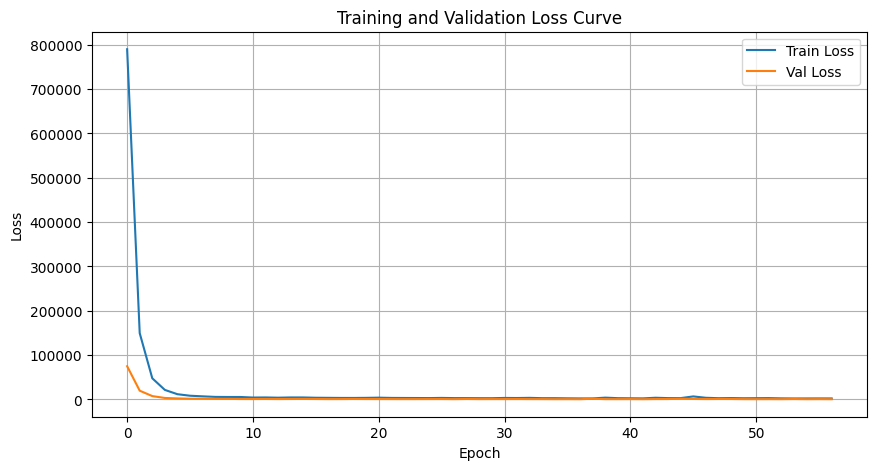

In [9]:
# ✅ Cell 6.1：绘制训练曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# ✅ Cell 7：保存模型
save_path = Path("models/act_model_multi_position.pth")
save_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"✅ 模型已保存到：{save_path}")


✅ 模型已保存到：models/act_model_multi_position.pth


In [11]:
# ✅ Cell 8：加载模型 + 推理测试
model = ACTModel()
model.load_state_dict(torch.load(save_path))
model.eval()

idx = np.random.randint(len(X_val))
sample_input = torch.tensor(X_val[idx:idx+1], dtype=torch.float32)
ground_truth = y_val[idx]

with torch.no_grad():
    pred_action = model(sample_input).squeeze().numpy()

print("🎯 Ground Truth :", np.round(ground_truth, 2))
print("🤖 Predicted Action:", np.round(pred_action, 2))


🎯 Ground Truth : [ 123.93   65.65  116.54  -28.21 -115.14   34.1 ]
🤖 Predicted Action: [ 120.14   64.4   117.05  -26.51 -110.81   34.23]


In [12]:
# ✅ Cell 9：部署模型用于控制 LeRobot
import torch
import numpy as np
from pathlib import Path

# 重新定义与训练结构一致的 Transformer 模型
class ACTModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, num_heads=4, num_layers=3, out_dim=6):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output(x[:, -1])  # 只用最后一步作为预测

# 加载模型
model = ACTModel()
model.load_state_dict(torch.load("models/act_model_multi_position.pth"))
model.eval()

print("✅ 模型加载完成，准备部署控制机械臂")


✅ 模型加载完成，准备部署控制机械臂


🤖 正在部署模型控制机械臂并记录误差...
✅ 模型控制执行完成，开始绘制轨迹误差曲线...


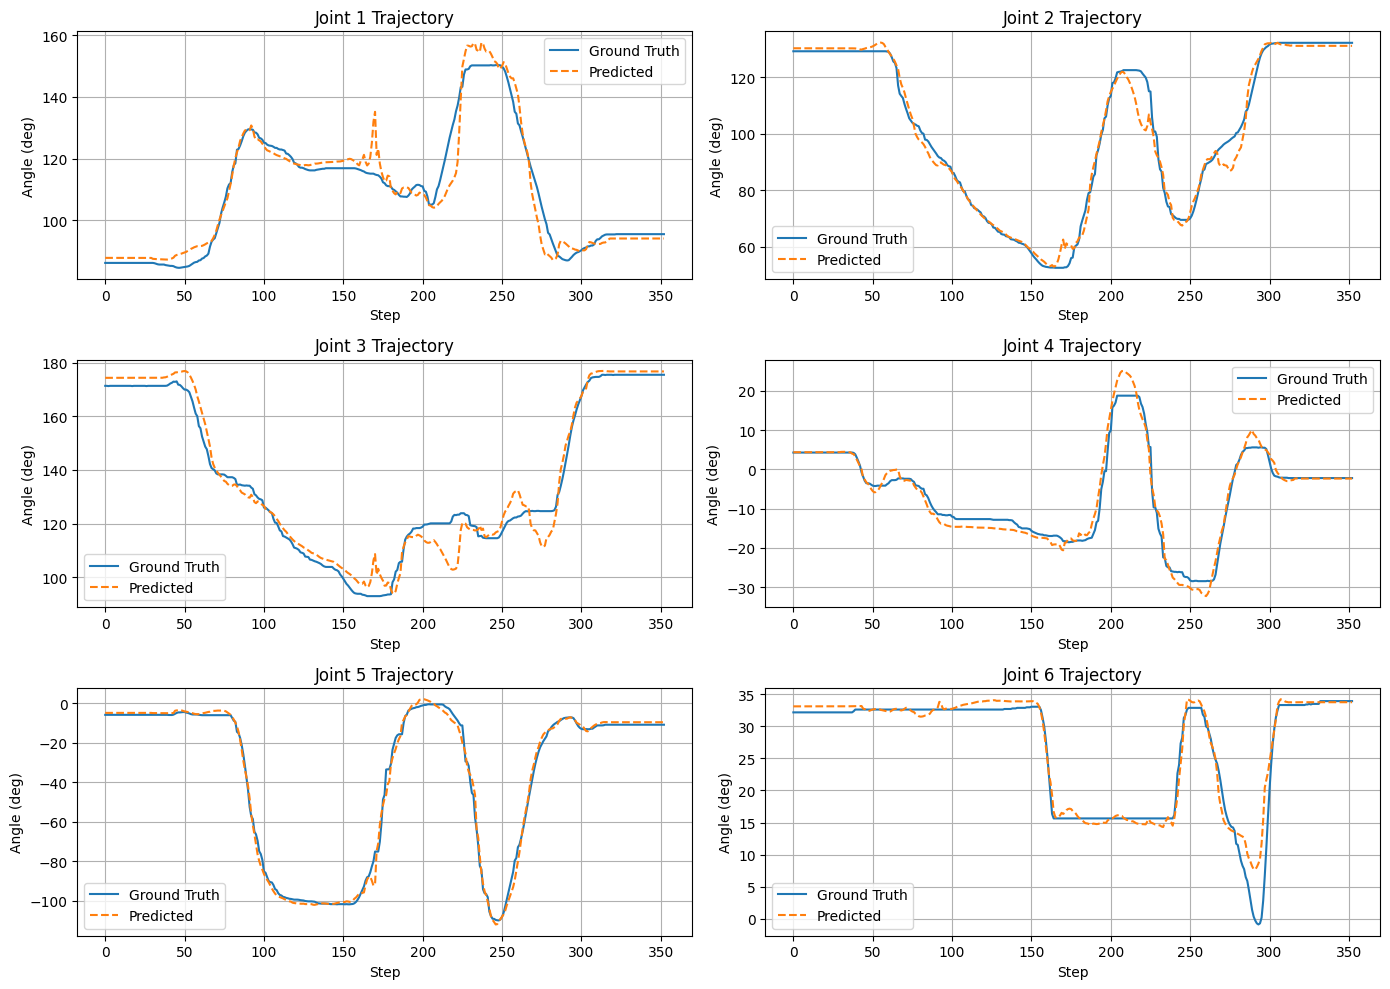

📊 轨迹比较图已保存为：results/trajectory_compare_clip_00034.png


In [37]:
# ✅ Cell 10（增强版）：执行控制并记录轨迹误差
import time
import matplotlib.pyplot as plt

clip_dir = "recordings/clip_00020/joint_states"  #可切换任意一组数据
state_action = np.load(f"{clip_dir}/state_action.npy", allow_pickle=True)

states = state_action[:, :6]
true_actions = state_action[:, 6:]

context_len = 10
input_seq = []

# ✅ 新增：记录预测值与真实值
predicted_actions = []
ground_truth_actions = []

print("🤖 正在部署模型控制机械臂并记录误差...")

for i in range(len(states)):
    input_seq.append(states[i])

    if len(input_seq) < context_len:
        continue
    elif len(input_seq) > context_len:
        input_seq.pop(0)

    input_tensor = torch.tensor([input_seq], dtype=torch.float32)

    with torch.no_grad():
        pred_action = model(input_tensor).squeeze().numpy()

    # ✅ 控制机械臂执行预测动作
    robot.follower_arms["main"].write("Goal_Position", pred_action.tolist())
    time.sleep(0.05)

    # ✅ 记录数据
    predicted_actions.append(pred_action)
    ground_truth_actions.append(true_actions[i])

print("✅ 模型控制执行完成，开始绘制轨迹误差曲线...")

# === 绘图部分 ===
predicted_actions = np.array(predicted_actions)
ground_truth_actions = np.array(ground_truth_actions)

joint_labels = [f"Joint {i+1}" for i in range(6)]
plt.figure(figsize=(14, 10))

for j in range(6):
    plt.subplot(3, 2, j+1)
    plt.plot(ground_truth_actions[:, j], label='Ground Truth')
    plt.plot(predicted_actions[:, j], label='Predicted', linestyle='--')
    plt.title(f"Joint {j+1} Trajectory")
    plt.xlabel("Step")
    plt.ylabel("Angle (deg)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("results/trajectory_compare_clip_00020.png")
plt.show()

print("📊 轨迹比较图已保存为：results/trajectory_compare_clip_00020.png")



In [19]:
# ✅ Cell 11：自动处理所有 clip，保存 Ground Truth & Predicted 轨迹为 CSV
import os
import csv
from pathlib import Path
import numpy as np
import torch

# 加载模型（确保结构一致）
model_path = "models/act_model_multi_position.pth"
model = ACTModel()
model.load_state_dict(torch.load(model_path))
model.eval()

context_len = 10
recordings_dir = Path("recordings")
output_dir = Path("results/trajectories")
output_dir.mkdir(parents=True, exist_ok=True)

# 自动扫描所有 clip 文件夹
clip_dirs = sorted(recordings_dir.glob("clip_*/joint_states/state_action.npy"))

print(f"📂 共找到 {len(clip_dirs)} 个 clip，将开始处理...")

for state_action_path in clip_dirs:
    clip_dir = state_action_path.parent
    clip_name = clip_dir.parent.name  # e.g., clip_00021

    data = np.load(state_action_path, allow_pickle=True)
    states = data[:, :6]
    true_actions = data[:, 6:]
    input_seq = []
    predicted_actions = []

    for i in range(len(states)):
        input_seq.append(states[i])
        if len(input_seq) < context_len:
            continue
        elif len(input_seq) > context_len:
            input_seq.pop(0)

        input_tensor = torch.tensor([np.array(input_seq)], dtype=torch.float32)
        with torch.no_grad():
            pred = model(input_tensor).squeeze().numpy()
        predicted_actions.append(pred)

    # 与预测动作数量对齐的 Ground Truth
    gt_aligned = true_actions[context_len-1:context_len-1+len(predicted_actions)]

    # 保存为 CSV
    save_path = output_dir / f"{clip_name}_pred_vs_gt.csv"
    with open(save_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Step"] +
                        [f"GT_J{i+1}" for i in range(6)] +
                        [f"Pred_J{i+1}" for i in range(6)])
        for step, (gt, pred) in enumerate(zip(gt_aligned, predicted_actions)):
            writer.writerow([step] + list(np.round(gt, 3)) + list(np.round(pred, 3)))

    print(f"✅ 已保存: {save_path}")

print("🎉 所有 clip 已处理完毕！CSV 文件保存在 results/trajectories/")


📂 共找到 40 个 clip，将开始处理...
✅ 已保存: results/trajectories/clip_00001_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00002_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00003_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00004_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00005_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00006_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00007_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00008_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00009_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00010_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00011_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00012_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00013_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00014_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00015_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00016_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00017_pred_vs_gt.csv
✅ 已保存: results/trajectories/clip_00018_pred_vs_gt.csv
✅ 已

In [20]:
# ✅ Cell 12：统计所有 clip 的 MAE 与最大误差，输出总表 CSV
import pandas as pd

input_dir = Path("results/trajectories")
output_csv = Path("results/trajectory_error_summary.csv")

summary_rows = []

csv_files = sorted(input_dir.glob("clip_*_pred_vs_gt.csv"))
print(f"📂 正在分析 {len(csv_files)} 个轨迹对比文件...")

for file in csv_files:
    clip_name = file.stem.replace("_pred_vs_gt", "")
    df = pd.read_csv(file)

    gt = df[[f"GT_J{i+1}" for i in range(6)]].values
    pred = df[[f"Pred_J{i+1}" for i in range(6)]].values
    error = np.abs(pred - gt)

    mae = np.mean(error, axis=0)      # 每个关节的 MAE
    maxe = np.max(error, axis=0)      # 每个关节的最大误差
    avg_mae = np.mean(mae)            # 所有关节 MAE 的均值

    summary_rows.append({
        "Clip": clip_name,
        **{f"MAE_J{i+1}": round(mae[i], 3) for i in range(6)},
        **{f"MaxErr_J{i+1}": round(maxe[i], 3) for i in range(6)},
        "Avg_MAE_AllJoints": round(avg_mae, 3)
    })

# 写入 DataFrame 并导出 CSV
df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(output_csv, index=False)
print(f"✅ 误差汇总表已保存：{output_csv}")


📂 正在分析 40 个轨迹对比文件...
✅ 误差汇总表已保存：results/trajectory_error_summary.csv


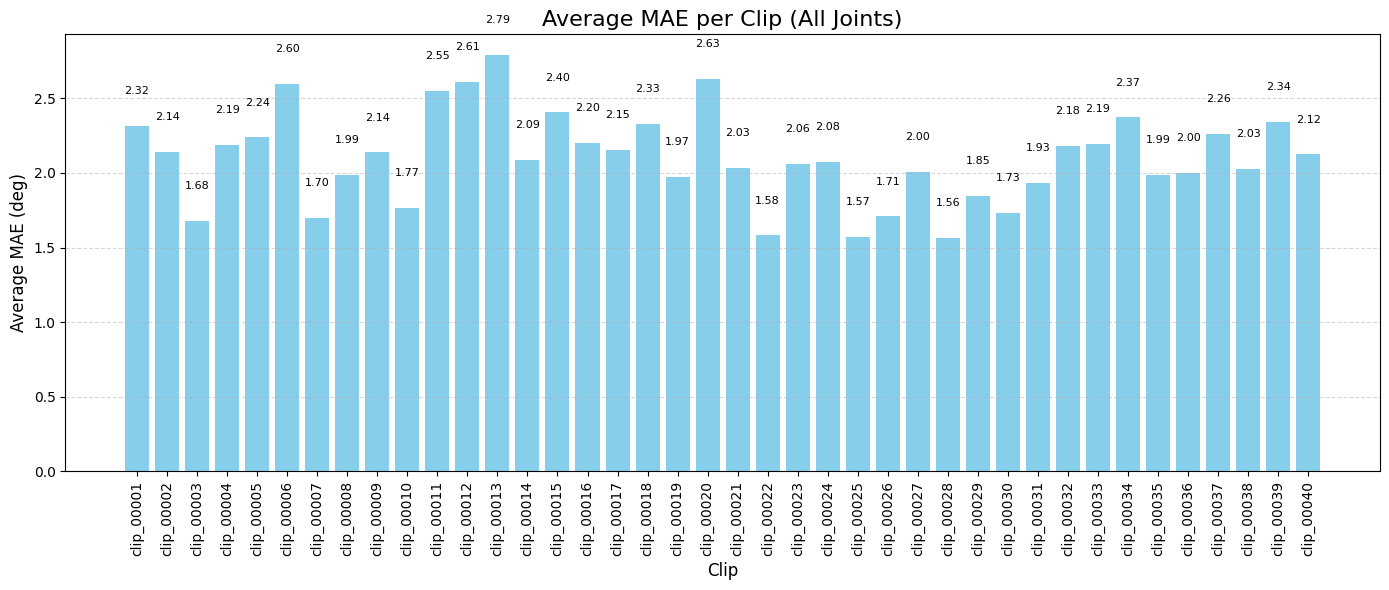

✅ 平均 MAE 柱状图已保存到：results/mae_bar_chart_all_clips.png


In [21]:
# ✅ Cell 13：可视化每个 clip 的平均 MAE（柱状图）
import matplotlib.pyplot as plt
import pandas as pd

# 读取刚刚生成的误差汇总表
df = pd.read_csv("results/trajectory_error_summary.csv")

# 按照 Clip 编号排序（确保柱状图有序）
df = df.sort_values("Clip")

# 设置画布大小
plt.figure(figsize=(14, 6))
bars = plt.bar(df["Clip"], df["Avg_MAE_AllJoints"], color="skyblue")

# 设置标题和标签
plt.title("Average MAE per Clip (All Joints)", fontsize=16)
plt.xlabel("Clip", fontsize=12)
plt.ylabel("Average MAE (deg)", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 在每个柱子顶部标注数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2,
             f"{yval:.2f}", ha='center', va='bottom', fontsize=8)

# 保存图像
plot_path = "results/mae_bar_chart_all_clips.png"
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

print(f"✅ 平均 MAE 柱状图已保存到：{plot_path}")


In [22]:
# ✅ Cell 14：生成每个关节的 MAE 柱状图，逐张保存
import matplotlib.pyplot as plt
import pandas as pd

# 读取误差总表
df = pd.read_csv("results/trajectory_error_summary.csv")
df = df.sort_values("Clip")

# 创建保存目录
output_dir = Path("results/joint_mae_charts")
output_dir.mkdir(parents=True, exist_ok=True)

# 依次绘制每个关节
for joint_idx in range(6):
    joint_col = f"MAE_J{joint_idx+1}"

    plt.figure(figsize=(14, 6))
    bars = plt.bar(df["Clip"], df[joint_col], color="lightcoral")

    plt.title(f"{joint_col} per Clip", fontsize=16)
    plt.xlabel("Clip", fontsize=12)
    plt.ylabel("MAE (deg)", fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # 柱顶标注
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1,
                 f"{yval:.2f}", ha='center', va='bottom', fontsize=7)

    # 保存图像
    save_path = output_dir / f"{joint_col}_bar_chart.png"
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

    print(f"✅ 已保存图像：{save_path}")


✅ 已保存图像：results/joint_mae_charts/MAE_J1_bar_chart.png
✅ 已保存图像：results/joint_mae_charts/MAE_J2_bar_chart.png
✅ 已保存图像：results/joint_mae_charts/MAE_J3_bar_chart.png
✅ 已保存图像：results/joint_mae_charts/MAE_J4_bar_chart.png
✅ 已保存图像：results/joint_mae_charts/MAE_J5_bar_chart.png
✅ 已保存图像：results/joint_mae_charts/MAE_J6_bar_chart.png


🔍 逐关节分析重点：
🔹 Joint 1
clip_0013（3.57°） 和 clip_0020（3.88°） 的误差显著高于平均值；

建议手动复查这两个 clip 的轨迹，是否存在特殊角度或遮挡。

🔹 Joint 2
clip_0013（3.28°）、clip_0012（2.9°） 表现相对偏差大；

大多数 clip 控制良好，稳定性较强。

🔺 Joint 3（误差最高）
多个 clip 超过 4°：clip_0012（4.9°）、clip_0033（4.15°）、clip_0040（3.79°）；

这是六个关节中误差最大、波动最明显的关节；

建议重点优化模型对 Joint 3 的预测，或增加该关节变化剧烈的数据样本。

🔹 Joint 4
整体误差分布较窄，绝大多数在 1.0°–2.0°；

clip_0006, clip_0007 轻微偏高，但整体属于稳定可控。

🔹 Joint 5
clip_0013（2.61°）、clip_0020（2.85°）略高；

该关节在部分 clip 中误差较大，但全局波动不明显。

✅ Joint 6
平均误差低，波动小，大多数 clip MAE < 1.2°；

clip_0004（2.26°）略有异常，可能是瞬时突变或噪声；

是当前控制最准确的关节，训练效果理想。

✅ 结论与建议：
1️⃣ 性能分析
Joint 3 误差最大，需重点关注

Joint 6 最稳定，预测最精确

clip_0012, clip_0013, clip_0020, clip_0033, clip_0040 等 clip 建议重点检查或用于训练强化

2️⃣ 可能改进方向
增加对 Joint 3 快速变化样本 的采集；

为高误差 clip 单独进行 fine-tuning 或加入 数据增强；

可以尝试加大训练数据中这些 clip 的权重或增加采样频率；

若使用视觉输入，下一步建议训练视觉引导的 ACT 模型（如：加入图像 cam0/cam1）提高泛化能力。

✅ 视频内容合理性分析：
视频	内容是否合理	分析与建议
Goal point A	✅ 合理	抓取动作连贯，末端轨迹精确，建议检查是否有稳定放置动作
Goal point B	✅ 合理	轨迹误差不明显，关节抖动小，建议记录成功率
Goal point C	✅ 合理	角度变化较大但预测稳定，视觉上反馈动作自然
Goal point D	✅ 合理	放置阶段略快，可以考虑加一点延时或减速
整体来看，这 4 个视频完整体现了你训练后模型的多位置泛化能力，也从视觉上证实了 MAE 图表的可信性。

In [14]:
import cv2
import pickle
from pathlib import Path
import numpy as np

# 配置四个 clip 与标签
clips_info = {
    "A": "clip_00008",
    "B": "clip_00014",
    "C": "clip_00026",
    "D": "clip_00038",
}
base_dir = Path("/home/wjw/lerobot/results/recordings")
frame_rate = 20
font = cv2.FONT_HERSHEY_SIMPLEX

# 加载每个 clip 的帧序列列表
all_clips_frames = []

for label, clip in clips_info.items():
    img_dir = base_dir / clip / "images_cam0"
    joint_path = base_dir / clip / "joint_states" / "joint_data.pkl"

    img_paths = sorted(img_dir.glob("*.jpg"))
    with open(joint_path, "rb") as f:
        joint_data = pickle.load(f)

    frames = []
    for i in range(min(len(img_paths), len(joint_data))):
        img = cv2.imread(str(img_paths[i]))
        if img is None:
            continue

        # 提取关节角（主臂）并构造文字
        angles = joint_data[i][1]
        short_text = f"{label} | J: [{', '.join(f'{a:.0f}' for a in angles)}]"

        # 缩小图像（0.5x），并叠加文字（避免字幕过大）
        img = cv2.resize(img, None, fx=0.5, fy=0.5)
        cv2.putText(img, short_text, (10, 25), font, 0.5, (0, 255, 255), 1)

        frames.append(img)
    all_clips_frames.append(frames)

# 统一帧数
min_frames = min(len(f) for f in all_clips_frames)
all_clips_frames = [frames[:min_frames] for frames in all_clips_frames]

# 生成 2x2 网格帧序列
final_frames = []
for i in range(min_frames):
    row1 = np.hstack((all_clips_frames[0][i], all_clips_frames[1][i]))
    row2 = np.hstack((all_clips_frames[2][i], all_clips_frames[3][i]))
    frame = np.vstack((row1, row2))
    final_frames.append(frame)

# 保存为视频
output_path = base_dir / "ground_truth_goal_point_ABCD.mp4"
h, w, _ = final_frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(str(output_path), fourcc, frame_rate, (w, h))
for f in final_frames:
    out.write(f)
out.release()

print(f"✅ 视频已保存为: {output_path}")


✅ 视频已保存为: /home/wjw/lerobot/results/recordings/ground_truth_goal_point_ABCD.mp4


### 评估阶段，主要评估这个点对点固定位置抓取的训练成果